### Flowers Segmentation Analysis using Dask framework

In [496]:
from os import path
import numpy as np
from dask_image import imread
from dask_image.ndmeasure import label
from dask import array as darr
import matplotlib.pyplot as plt
%matplotlib inline

First, we need to read the data provided for analysis. To do so we're using the `*` pattern so that Dask's `imread` function reads all images in the data directory. Doing so, we obtain a `dask.array` with a shape of `(210, 128, 128, 4)` splitted in `210` Chunks of `(128, 128, 4)` dimensions.

In [59]:
flowers_arr = imread.imread(path.join("../data/flower_images/", "*.png"))
flowers_arr

,Array,Chunk
Bytes,55.05 MB,262.14 kB
Shape,"(210, 128, 128, 4)","(1, 128, 128, 4)"
Count,630 Tasks,210 Chunks
Type,float32,numpy.ndarray


First step of the processing pipeline we're trying to create is to bring all images to grayscale tones. Also, as we're dealing with a dask array already, we can code a function that treats one image a time but Dask will be able to parallelize it over all chunks of our images array.

For this we're using the equation to calculate [luminance](http://www.poynton.com/PDFs/ColorFAQ.pdf): `Y = 0.2125 R + 0.7154 G + 0.0721 B`. Of course, as a result, we'eliminating the 4th dimension which was the number of channels due to the change from RGB to GrayScale tones.

dask.array<add, shape=(210, 128, 128), dtype=float32, chunksize=(1, 128, 128), chunktype=numpy.ndarray>

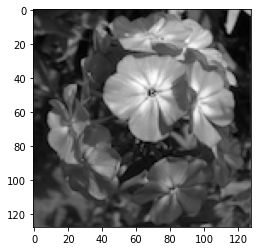

In [221]:
def grayscale(img):
    result = ((img[..., 0] * 0.2125) +
              (img[..., 1] * 0.7154) +
              (img[..., 2] * 0.0721))
    return result
gray_arr = grayscale(flowers_arr)
plt.imshow(gray_arr[0], cmap='gray')
gray_arr

The next step in our image processing pipeline is to apply the segmentation over the grayscale images. Based on the same parallelization principle, we only have to code a function that applies the transformation to one image/chunk and Dask will deal with the distributing part of the work.

For this step, we segment regions of interest from the data. We’ll use a simple arbitrary threshold as the cutoff, at 75% of the maximum intensity of the treated image. Also, to apply this transformation over all images of our array, we're using `dask.array.map_blocks` function which automatically detects the independent chunks in our array and applies the function over their axis. And as we're not changing the dimension of our inner elements, nor of the outer array, we don't need to specify the output chunks dimensions.

The image shown below represents the segmented parts of the example image shown above.

dask.array<segment, shape=(210, 128, 128), dtype=bool, chunksize=(1, 128, 128), chunktype=numpy.ndarray>

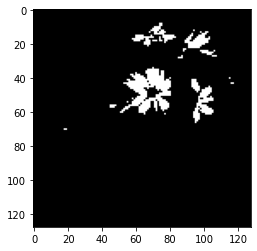

In [580]:
def segment(block):
    return block > (0.75 * block.max())

segmented_arr = gray_arr.map_blocks(segment)
plt.imshow(segmented_arr[0], cmap='gray')
segmented_arr

Next, we label each region of connected pixels above the threshold value. For this we use the `label` function from `dask_image.ndmeasure`. This will return both the label image, and the number of labels.

dask.array<lambda, shape=(210, 128, 128), dtype=int32, chunksize=(1, 128, 128), chunktype=numpy.ndarray>

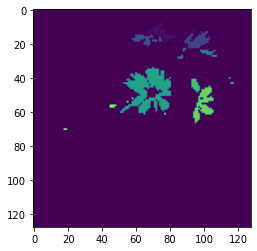

In [579]:
relabeled = segmented_arr.map_blocks(lambda x: label(x)[0])
plt.imshow(relabeled[0])
relabeled

Having these relabelled images, we can compute the number of the different labels on each image of our Dask array. Then, we can easily plot the demanded histogram of the total number of images per number of labels in our provided dataset.

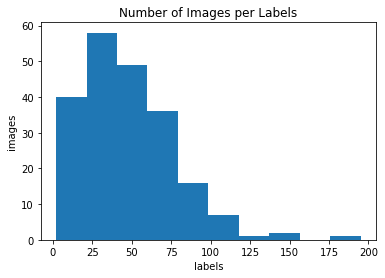

In [585]:
labels = relabeled.max(axis=(1,2)).compute().compute()
plt.hist(labels)
plt.xlabel("labels")
plt.ylabel("images")
plt.title("Number of Images per Labels");